# Exercise 4. Neural Networks Learning

In this exercise, you will implement the ```backpropagation algorithm for neural networks```
and apply it to the task of hand-written digit recognition. Before starting on the 
programming exercise, we strongly recommend watching the video lectures and completing 
the review questions for the associated topics.
For details see **ex4.pdf**

We will implement a Neural Networks class **```DigitImageNeuralNetwork```** to predict 20x20 pixel digit (0,1...9) image using mathematical concepts and algorithms without using any ML library then in the following section we will use it in exercise 4 of the course.

The class is split into multiple cells using **```jdc```** package so that notes can be written for learning and understanding. Complete implementation of the class is under **```src/supervised/neural_networks/digit_image_nn.py```** module of this repository.

Following cell declares the class **```DigitImageNeuralNetwork```** with its basic attributes and common utility members.

In [40]:
import jdc
import numpy as np
import scipy.optimize as opt
import src.utils.label_mapping as mappings
import src.utils.displaydata as disp

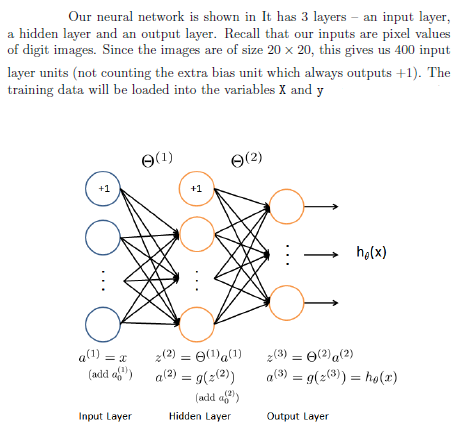

In [41]:
class DigitImageNeuralNetwork(object):
    '''
    Neural Network implementation to predict
    20x20 pixel digit (0,1...9) image.
    '''
    def __init__(self, input_layer_size, hidden_layer_size,
                   output_layer_size):
        '''
        Initialize attributes.
        '''
        self.min_cost = None
        self.min_theta1 = None
        self.min_theta2 = None
    
        self.input_layer_size  = input_layer_size
        self.hidden_layer_size = hidden_layer_size
        self.output_layer_size = output_layer_size
    
    
    def train(self, X, y, lmda):
        '''
        Train the neural networks parameters. Call scipy's
        fming_cg function for optimization.
    
        Arguments:
          X (m x n float matrix): Training examples.
          y (m 1d int array): Outputs of training examples.
          lmda (float): Lambda value for regularization.
        '''
        theta1 = self._rand_init_weights(self.input_layer_size,
                                         self.hidden_layer_size)
        theta2 = self._rand_init_weights(self.hidden_layer_size, 
                                         self.output_layer_size)
        theta = self.unroll(theta1, theta2)
        args = (X, y, lmda)
    
        res = opt.fmin_cg(self._cost, 
                          x0=theta, 
                          fprime=self._gradient_backpropagation,
                          args=args, 
                          maxiter=50, 
                          disp=False, 
                          full_output=True)
        # Save min cost and thetas.
        self.min_theta1, self.min_theta2 = self.roll(res[0])
        self.min_cost = res[1]
        print('cost {}'.format(self.min_cost))
    
    
    def predict(self, V):
        '''
        Predict for test examples, remember labels will
        be according to Matlab indexing, there is need
        to convert it accordingly. The labels are in the
        range 1..K, where K = size(all_theta, 1).
    
        Arguments:
          V (m x n float matrix): Training examples.
    
        Return:
          (1d int row vector): Predicted labels.
        '''
        m = V.shape[0]
        labels = np.zeros(m, dtype=np.int32)
        theta1 = self.min_theta1.transpose()
        theta2 = self.min_theta2.transpose()
    
        for i in range(m):
          h = self._forward(V[[i],:], theta1, theta2)
          labels[i] = np.argmax(h)
        return labels
    
    
    def roll(self, theta):
        '''
        Roll theta1 and theta2 matrices.
    
        Arguments:
          theta (unrolled thetas vector): Unrolled theta1 and theta2.
    
        Return:
          (theta1 matrix): Rolled theta1 matrix.
          (theta2 matrix): Rolled theta2 matrix.
        '''
        boundary = self.hidden_layer_size * (self.input_layer_size + 1)
        theta1_shape = (self.hidden_layer_size, (self.input_layer_size + 1))
        theta2_shape = (self.output_layer_size, (self.hidden_layer_size + 1))
    
        theta1 = np.reshape(theta[:boundary], theta1_shape)
        theta2 = np.reshape(theta[boundary:], theta2_shape)
        return theta1, theta2
    
    
    def unroll(self, theta1, theta2):
        '''
        Unroll theta1 and theta2 into a vector.
    
        Arguments:
          theta1 (matrix): theta1 matrix.
          theta2 (matrix): theta2 matrix.
    
        Return:
          (thetas vector): Unrolled theta1 and theta1 into a vector.
        '''
        return np.concatenate((theta1.ravel(), theta2.ravel()))

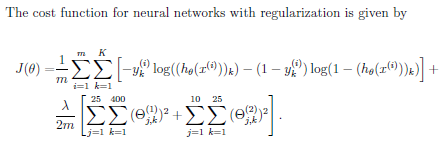

In [42]:
%%add_to DigitImageNeuralNetwork

def _cost(self, theta, X, y, lmda):
    '''
    Compute cost for given 'theta1' and 'theta2'.
    Assumes 'X' has column of 1s i.e x0=1 added.

    Arguments:
      theta (float vector): Parameters/weights.
      X (m x n float matrix):  Training examples.
      y (m 1d int array): Outputs of training examples.
      lmda (float): Lambda value for regularization.

    Return:
      (float): Cost value.
    '''
    # Form thetas.
    theta1, theta2 = self.roll(theta)
    # We need transposed in computation.
    theta1 = theta1.transpose()
    theta2 = theta2.transpose()

    cost = 0.0
    m = X.shape[0]
    for i in range(m):
      h = self._forward(X[[i],:], theta1, theta2)

      # Create a column vector for y output of the
      # current row.
      y_vect = np.zeros(shape=(self.output_layer_size, 1))
      # Set the cell that has output of the image.
      y_vect[mapping.output_layer_index_matlab(y[i]), 0] = 1

      likelihood = 0.0
      for k in range(h.shape[1]):
        hk = h[0,k]
        yk = y_vect[k,0]
        likelihood += -(yk * np.log(hk)) - ((1.0 - yk) * np.log(1.0 - hk))
      cost += likelihood

    # Regularization theta1
    reg1 = 0.0
    for k in range(1, theta1.shape[0]):
      for j in range(0, theta1.shape[1]):
        reg1 += theta1[k, j] ** 2

    # Regularization theta2
    reg2 = 0.0
    for k in range(1, theta2.shape[0]):
      for j in range(0, theta2.shape[1]):
        reg2 += theta2[k, j] ** 2
    c = (cost / m) + ((reg1 + reg2) * (lmda / (2 * m)))
    return (cost / m) + ((reg1 + reg2) * (lmda / (2 * m)))

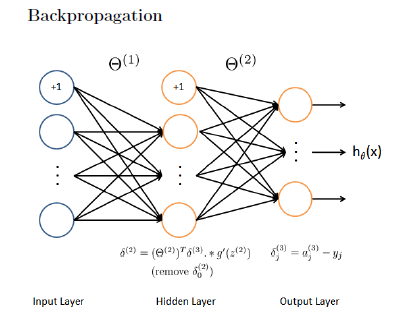

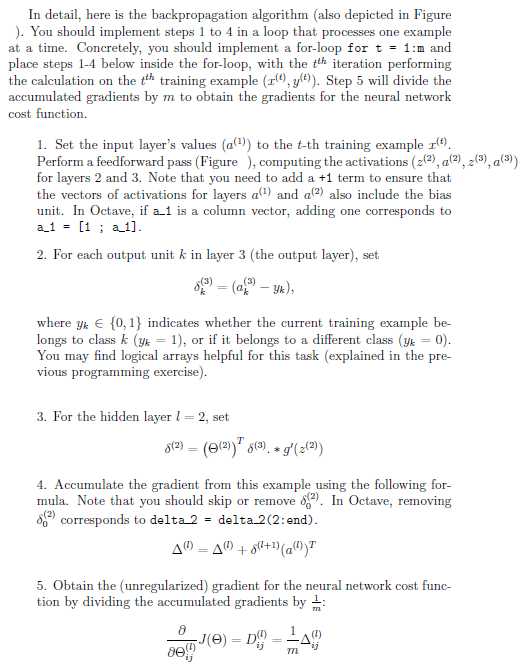

In [43]:
%%add_to DigitImageNeuralNetwork

def _gradient_backpropagation(self, theta, X, y, lmda):
    '''
    Compute gradient for given 'theta1' and 'theta2'.
    Assumes 'X' has column of 1s i.e x0=1 added.

    Arguments:
      theta (float vector): Parameters/weights.
      X (m x n float matrix):  Training examples.
      y (m 1d int array): Outputs of training examples.
      lmda (float): Lambda value for regularization.

    Return:
      (float vector): Unrolled theta1 and theta2 vector.
    '''
    # Form thetas.
    theta1, theta2 = self.roll(theta)
    gradient1 = np.zeros_like(theta1)
    gradient2 = np.zeros_like(theta2)

    # We need transposed in computation.
    theta1 = theta1.transpose()
    theta2 = theta2.transpose()

    m = X.shape[0]
    for i in range(m):
      a1 = X[[i],:]
      z2 = np.dot(a1, theta1)
      a2 = np.ones(shape=(a1.shape[0], theta2.shape[0]))
      a2[:,1:] = self.__sigmoid(z2)
      z3 = np.dot(a2, theta2)
      a3 = self.__sigmoid(z3)

      # Create a column vector for y output of the current
      # row. Set the cell that has output of the image.
      yk = np.zeros(shape=(self.output_layer_size, 1))
      yk[mapping.output_layer_index_matlab(y[i]), 0] = 1

      # 'Error term' for output layer.
      delta3 = a3.transpose() - yk

      # 'Error term' for hidden layer.
      gprime = np.ones(shape=(z2.shape[0], z2.shape[1] + 1))
      gprime[:,1:] = self._sigmoid_gradient(z2)
      gprime = gprime.transpose()
      delta2 = theta2.dot(delta3) * gprime
      # deleting bias delta2[0].
      delta2 = delta2[1:,:]

      # Accumulate the gradient from this example.
      # Layer1.
      gradient1 = gradient1 + delta2.dot(a1)
      # Layer2.
      gradient2 = gradient2 + delta3.dot(a2)

    gradient1 /= m
    gradient2 /= m
    theta1 = theta1.transpose()
    theta2 = theta2.transpose()
    # Add regularization.
    gradient1[:,1:] += (theta1[:,1:] * (lmda / m))
    gradient2[:,1:] += (theta2[:,1:] * (lmda / m))

    return self.unroll(gradient1, gradient2)

In [44]:
%%add_to DigitImageNeuralNetwork

def _forward(self, X, theta1, theta2):
    '''
    Compute hypothesis of an input given a 3 layers trained
    neural network by forwarding.

    Arguments:
      X (m x n float matrix):  Training examples.
      theta1 (m x n float matrix): Pre-calculated layer 1 parameters/weights.
      theta2 (m x n float matrix): Pre-calculated layer 2 parameters/weights.

    Return:
      (1d float array): Hypothetical values row vector.
    '''
    z2 = np.dot(X, theta1)
    a2 = np.ones(shape=(X.shape[0], theta2.shape[0]))
    a2[:,1:] = self.__sigmoid(z2)
    z3 = np.dot(a2, theta2)
    hyp = self.__sigmoid(z3)
    return hyp

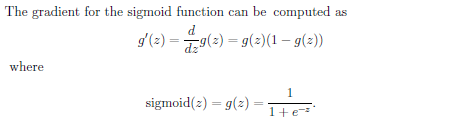

In [45]:
%%add_to DigitImageNeuralNetwork

def _sigmoid_gradient(self, z):
    '''
    Compute sigmoid gradient.

    Arguments:
      z (scalar, vector, matrix): Neuron or unit value.

    Return:
      Sigmoid gradient values, same size as 'z'.
    '''
    g = self.__sigmoid(z)
    return g * (1.0 - g)

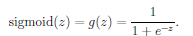

In [46]:
%%add_to DigitImageNeuralNetwork

def __sigmoid(self, z):
    '''
    Sigmoid function for scalar, vector or matrix.

    Arguments:
      z (scalar, vector, matrix): Neuron or unit value.

    Return:
      Sigmoid values, same size as 'z'.
    '''
    return 1.0 / (1.0 + np.exp(-z))

In [47]:
%%add_to DigitImageNeuralNetwork

def _rand_init_weights(self, layer_in, layer_out):
    '''
    Randomly initialize the weights of a layer with 'layer_in'
    incoming connections and 'layer_out' outgoing connections.

    Arguments:
      layer_in (int): Incoming connections.
      layer_out (int): Outgoing connections.

    Return:
      (m * n float matrix): Randomly generated matrix.
    '''
    # Strategy for random initialization is to randomly 
    # select values for 'theta^layer' uniformly in the
    # range [-eps, eps] where eps = 0.12.
    # This range of values ensures that the parameters
    # are kept small and makes the learning more efficient.
    eps = 0.12
    weights = (np.random.rand(layer_out, 1 + layer_in) * 2 * eps) - eps
    return weights

### Course Exercise No 4 'Neural Networks Learning'. For detailed description of the exercise see "ex4.pdf"
#### This exercise uses the class "DigitImageNeuralNetwork" we implemented above.
#### Solution of whole excercise is available in a single class definitions see ```src/exercises/coursera/ex4.py```

### Utility functions and parameters for the exercise

In [48]:
# 20x20 Input Images of Digits.
input_layer_size = 400

# 25 hidden units.
hidden_layer_size = 25

# 10 output units.
output_layer_size = 10


def _debug_init_weights(fan_out, fan_in):
    '''
    Helper routine for debugging.
    Initialize the weights of a layer with 'fan_in' incoming
    connections and 'fan_out' outgoing connections using a fix
    set of values

    Arguments:
      fan_out (int): Incoming connections.
      fan_in (int): Outgoing connections.

    Return:
      (1 + fan_in) x (fan_out) float matrix: Weights.
    '''
    # Set weights to zeros
    weights = np.zeros(shape=(fan_out, 1 + fan_in));

    # Initialize wights using "sin", this ensures that
    # weight is always of the same values and will be
    # useful for debugging.
    weights = np.sin(weights) / 10.0
    return weights


def compute_numerical_gradient(X, y, theta1, theta2, lmda, dig_nn):
    '''
    Compute the numerical gradient around 'theta1' and 'theta2'.
    It implements numerical gradient checking, and returns the 
    numerical gradient.

    Arguments:
      X (m x n float matrix): Training examples.
      y (m 1d int array): Outputs of training examples.
      theta1 (m x n float matrix): Pre-calculated layer 1 parameters/weights.
      theta2 (m x n float matrix): Pre-calculated layer 2 parameters/weights.
      lmda (float): Lambda value for regularization.
      dig_nn (DigitImageNeuralNetwork): Instance of the class.

    Return:
      (float row vector): Numerical gradients. 
    '''
    numgrad = np.zeros(theta1.size + theta2.size)
    perturb1 = np.zeros_like(theta1)
    perturb2 = np.zeros_like(theta2)
    e = 1e-4;
    p = 0

    # Considering for theta1.
    for i in range(theta1.shape[0]):
      for j in range(theta1.shape[1]):
        # Set perturbation vector.
        perturb1[i, j] = e
        loss1 = dig_nn._cost(dig_nn.unroll((theta1 - perturb1), 
                                           (theta2 - perturb2)), X, y, lmda)
        loss2 = dig_nn._cost(dig_nn.unroll((theta1 + perturb1), 
                                           (theta2 + perturb2)), X, y, lmda)
        # Compute Numerical Gradient.
        numgrad[p] = (loss2 - loss1) / (2.0 * e)
        perturb1[i, j] = 0
        p += 1

    # Considering theta2.
    for i in range(theta2.shape[0]):
      for j in range(theta2.shape[1]):
        # Set perturbation vector.
        perturb2[i, j] = e
        loss1 = dig_nn._cost(dig_nn.unroll((theta1 - perturb1), 
                                           (theta2 - perturb2)), X, y, lmda)
        loss2 = dig_nn._cost(dig_nn.unroll((theta1 + perturb1), 
                                           (theta2 + perturb2)), X, y, lmda)
        # Compute Numerical Gradient.
        numgrad[p] = (loss2 - loss1) / (2.0 * e)
        perturb2[i, j] = 0
        p += 1
    return numgrad


def check_gradients(lmda):
    '''
    Test gradient computation of the class 'DigitImageNeuralNetwork'.

    Arguments:
      lmda (float): Lambda value for regularization.
    '''
    print('Checking gradients when lambda = ' + str(lmda))
    input_layer_size = 3
    hidden_layer_size = 5
    output_layer_size = 3
    m = 5

    # We generate some 'random' test data.
    theta1 = _debug_init_weights(hidden_layer_size, input_layer_size)
    theta2 = _debug_init_weights(output_layer_size, hidden_layer_size)

    # Reusing _debug_init_weights to generate X.
    M  = _debug_init_weights(m, input_layer_size - 1)
    # We add a column i.e x0=1 hence shape becomes m x n+1.
    X = np.ones(shape=(M.shape[0], M.shape[1] + 1))
    X[:,1:] = M
    y  = 1 + np.mod(np.arange(m), output_layer_size)

    dig_nn = DigitImageNeuralNetwork(input_layer_size, 
                                       hidden_layer_size,
                                       output_layer_size)
    # Get gradient empirically.
    grad = dig_nn._gradient_backpropagation(dig_nn.unroll(theta1, theta2), X, y, lmda)
    # Get gradient numerically.
    numgrad = compute_numerical_gradient(X, y, theta1, theta2, lmda, dig_nn)

    # Evaluate the norm of the difference between two solutions.  
    # difference should be less than 1e-9
    diff = np.linalg.norm(numgrad - grad) / np.linalg.norm(numgrad + grad)
    print('Empirical grad calculation.')
    print(grad)
    print('Numerical grad calculation.')
    print(numgrad)
    print('The relative difference shall be less than 1e-9.')
    print('difference = ' + str(diff) + ' test passed.')

### Part 1: Loading and visualizing data

In [49]:
# Read training examples matrix size is m x n.
# Images data is same as exercise 3.
M = np.loadtxt('data/ex3data1_X.dat', delimiter=',')

# Must be array of size 'M.rows'.
# Images data is same as exercise 3.
y = np.loadtxt('data/ex3data1_y.dat', delimiter=',', dtype='int')

print('M {}'.format(M.shape))
print('y {}'.format(y.shape))

M (5000, 400)
y (5000,)


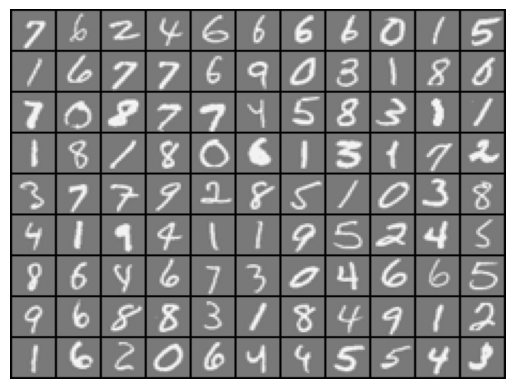

In [50]:
# Randomly select 100 data points to display.
selimgs = np.random.permutation(M.shape[0])
selimgs = selimgs[1:100]
disp.displaydata(M[selimgs,:])

## Part 2: Loading saved neural network parameters

In [51]:
# Read pre trained theta1 parameters matrix.
theta1 = np.loadtxt('data/ex4weights_theta1.dat', delimiter=',')

# Read pre trained theta1 parameters matrix.
theta2 = np.loadtxt('data/ex4weights_theta2.dat', delimiter=',')

print('theta1 {}'.format(theta1.shape))
print('theta2 {}'.format(theta2.shape))

theta1 (25, 401)
theta2 (10, 26)


### Part 3,4: Compute Feedforward cost with regularization

In [52]:
# We add a column i.e x0=1 hence shape becomes m x n+1.
X = np.ones(shape=(M.shape[0], M.shape[1] + 1))
# First column will be 1.
X[:,1:] = M

dig_nn = DigitImageNeuralNetwork(input_layer_size,
                                        hidden_layer_size,
                                        output_layer_size)
# Weight regularization parameter (we set this to 1 here) lambda = 1.
lmda = 1
cost = dig_nn._cost(dig_nn.unroll(theta1, theta2), X, y, lmda)
print('cost = {} test passed.'.format(cost))

cost = 0.3837698590909235 test passed.


### Part 5: Compute sigmoid gradient

In [53]:
sig_grad = dig_nn._sigmoid_gradient(np.array([1, -0.5, 0, 0.5, 1]))
print('Sigmoid gradient = {} test passed.'.format(sig_grad))

Sigmoid gradient = [0.19661193 0.23500371 0.25       0.23500371 0.19661193] test passed.


### Part 6: Randomly initializing Neural Network parameters/weights

In [54]:
init_theta1 = dig_nn._rand_init_weights(input_layer_size, hidden_layer_size)
init_theta2 = dig_nn._rand_init_weights(hidden_layer_size, output_layer_size)
print('Parameters initialization init_theta1 = {}, init_theta2 = {} test passed'
      .format(init_theta1.shape, init_theta2.shape))

Parameters initialization init_theta1 = (25, 401), init_theta2 = (10, 26) test passed


### Part 7,8: Checking Backpropagation with and without regularization

In [55]:
lmda=0
print('Without regularization...')
check_gradients(lmda)
lmda = 3
print('\n\nWith regularization...')
check_gradients(lmda)

cost = dig_nn._cost(dig_nn.unroll(theta1, theta2), X, y, lmda)
print('\n\nCost at debugging parameters (with lambda = 3) should be about 0.576051.')
print('cost = {}. test passed'.format(cost))

Without regularization...
Checking gradients when lambda = 0
Empirical grad calculation.
[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.1  0.05 0.05 0.05 0.05 0.05 0.1  0.05
 0.05 0.05 0.05 0.05 0.3  0.15 0.15 0.15 0.15 0.15]
Numerical grad calculation.
[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.1  0.05 0.05 0.05 0.05 0.05 0.1  0.05
 0.05 0.05 0.05 0.05 0.3  0.15 0.15 0.15 0.15 0.15]
The relative difference shall be less than 1e-9.
difference = 4.952371672559128e-12 test passed.


With regularization...
Checking gradients when lambda = 3
Empirical grad calculation.
[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.1  0.05 0.05 0.05 0.05 0.05 0.1  0.05
 0.05 0.05 0.05 0.05 0.3  0.15 0.15 0.15 0.15 0.15]
Numerical grad calculation.
[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.  

### Part 9: Training Neural Network

In [56]:
print('Please wait (it might take a few minutes)...')
lmda = 1
dig_nn.train(X, y, lmda)
pred = dig_nn.predict(X)

# Map labels from Matlab 1-based indexing to 
# Python 0-based indexing.
pred = mappings.labels_matlab2python(pred)

print('Original label for each example')
print(y)
print('Predicted label for each example')
print(pred)
print('Predicted accuracy {}%.\n'.format(np.mean(pred == y) * 100))

Please wait (it might take a few minutes)...
cost 0.4386709187742196
Original label for each example
[0 0 0 ... 9 9 9]
Predicted label for each example
[0 0 0 ... 9 9 9]
Predicted accuracy 96.41999999999999%.

